# A method to portray the PL proof outlined in Figure 11.6
 
##  THIS NOTEBOOK is referenced in Asg-8 and Quiz-8
 

In [1]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
import sys

# -- Detect if in Own Install or in Colab
try:
    import google.colab
    OWN_INSTALL = False
except:
    OWN_INSTALL = True
    
if OWN_INSTALL:
    
  #---- Leave these definitions ON if running on laptop
  #---- Else turn OFF by putting them between ''' ... '''

  sys.path[0:0] = ['../../../../..',  '../../../../../3rdparty',  
                   '../../../..',  '../../../../3rdparty',  
                   '../../..',     '../../../3rdparty', 
                   '../..',        '../../3rdparty',
                   '..',           '../3rdparty' ]

else: # In colab
  ! if [ ! -d Jove ]; then git clone https://github.com/ganeshutah/Jove Jove; fi
  sys.path.append('./Jove')
  sys.path.append('./Jove/jove')

# -- common imports --
from jove.lex import lex
from jove.yacc import yacc

from jove.StateNameSanitizers import ResetStNum, NxtStateStr
from jove.SystemImports       import *

from jove.Def_NFA import mk_nfa
from jove.DotBashers import *

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

You may use any of these help commands:
help(ResetStNum)
help(NxtStateStr)

You may use any of these help commands:
help(mkp_dfa)
help(mk_dfa)
help(totalize_dfa)
help(addtosigma_delta)
help(step_dfa)
help(run_dfa)
help(accepts_dfa)
help(comp_dfa)
help(union_dfa)
help(intersect_dfa)
help(pruneUnreach)
help(iso_dfa)
help(langeq_dfa)
help(same_status)
help(h_langeq_dfa)
help(fixptDist)
help(min_dfa)
help(pairFR)
help(state_combos)
help(sepFinNonFin)
help(bash_eql_classes)
help(listminus)
help(bash_1)
help(mk_rep_eqc)
help(F_of)
help(rep_of_s)
help(q0_of)
help(Delta_of)
help(mk_state_eqc_name)

You may use any of these help commands:
help(mk_nfa)
help(totalize_nfa)
help(step_nfa)
help(run_nfa)
help(ec_step_nfa)
help(Eclosure)
help(Echelp)
help(accepts_nfa)
help(nfa2dfa)
help(n2d)
help(inSets)
help(rev_dfa)
help(min_dfa_brz)



# Variant of example on Page 154

## Grammar of bracketing types introduced

S -> (S) | T   # ADDING another EPS production here as in the book causes ambiguity!

T -> [ T ] | T T | EPS


In [2]:
# Tokens in our CFG
tokens = ('LSQ','RSQ','LPAREN','RPAREN', 'EPS')  

t_EPS     = r'\'\'|\"\"'   
t_LSQ     = r'\['
t_RSQ     = r'\]'
t_LPAREN  = r'\('
t_RPAREN  = r'\)'
 

# Ignored characters
t_ignore = " \t"

def t_newline(t):
    r'\n+'
    t.lexer.lineno += t.value.count("\n")
    
def t_error(t):
    print("Illegal character '%s'" % t.value[0])
    t.lexer.skip(1)
    
def p_paren(t):
    'S : LPAREN S RPAREN'
    #--------------------
    nlin = t[2]['nl']
    elin = t[2]['el']
    
    rootin = nlin[0]
    
    root = NxtStateStr("S_")
    left = NxtStateStr("(_")
    right= NxtStateStr(")_")
    
    t[0] = { 'nl' : [root, left] + nlin + [right], #order important f. proper layout!
             'el' : elin + [ (root, left),
                             (root, rootin),
                             (root, right) ]
           }
    
def p_T(t):
    'S : T'
    #
    nlin = t[1]['nl']
    elin = t[1]['el']    
    rootin = nlin[0]   
    root = NxtStateStr("S_")   
    t[0] = { 'nl' : [root] + nlin, #order important f. proper layout!
             'el' : elin + [ (root, rootin) ]
           }
    

def p_sq(t):
    'T : LSQ T RSQ'
    #--------------------
    nlin = t[2]['nl']
    elin = t[2]['el']
    
    rootin = nlin[0]
    
    root = NxtStateStr("T_")
    left = NxtStateStr("[_")
    right= NxtStateStr("]_")
    
    t[0] = { 'nl' : [root, left] + nlin + [right], #order important f. proper layout!
             'el' : elin + [ (root, left),
                             (root, rootin),
                             (root, right) ]
           }

def p_TT(t):
    'T : T T'
    #--------------------
    nlin1 = t[1]['nl']
    elin1 = t[1]['el']
    nlin2 = t[2]['nl']
    elin2 = t[2]['el']
    
    rootin1 = nlin1[0]
    rootin2 = nlin2[0]
    
    root = NxtStateStr("T_")
    
    t[0] = { 'nl' : [root] + nlin1 + nlin2, #order important f. proper layout!
             'el' : elin1 + elin2 + [ (root, rootin1),
                                      (root, rootin2) ]                      
           }
    
def p_eps_T(t):
    'T : EPS'
    #--------
    nlin = [ NxtStateStr("@_") ]
    elin = [ ]   
    rootin = nlin[0]   
    root = NxtStateStr("T_")   
    t[0] = { 'nl' : [root] + nlin, #order important f. proper layout!
             'el' : elin + [ (root, rootin) ]
           }
    
 
    
def p_error(t):
    print("Syntax error at '%s'" % t.value)

#--
def parseSinit():
    """In: a string s containing a regular expression.
       Out: An attribute quadruple (nfa,ast,nodelist,edgelist)        
    """
    mylexer  = lex()
    myparser = yacc()
    return (mylexer, myparser)

#--
def parseS(s, L, P):
    """In: a string s containing a regular expression.
       Out: An attribute quadruple (nfa,ast,nodelist,edgelist)        
    """
    mylexer  = L
    myparser = P
    #-- pass the right lexer into the parser    
    p = myparser.parse(s, lexer = mylexer)  
    return (p['nl'], p['el'])       

In [3]:
def drawPT(nl_el, comment="PT"):
    """Given an (nfa, ast, nl, el) quadruple where nl is the node and el the edge-list,
       draw the Parse Tree by returning a dot object. Also return the NFA dot object.
    """
    (nl, el) = nl_el
    dotObj_pt = Digraph(comment)
    dotObj_pt.graph_attr['rankdir'] = 'TB'
    for n in nl:
        prNam = n.split('_')[0]
        dotObj_pt.node(n, prNam, shape="oval", peripheries="1")
    for e in el:
        dotObj_pt.edge(e[0], e[1])
    return dotObj_pt

In [4]:
(L, P) = parseSinit()

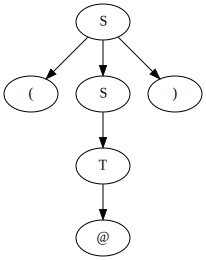

In [5]:
drawPT(parseS("('')", L, P))

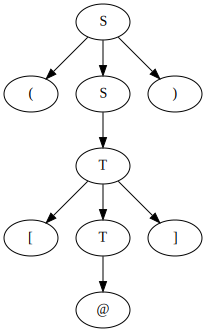

In [6]:
drawPT(parseS("([''])", L, P))

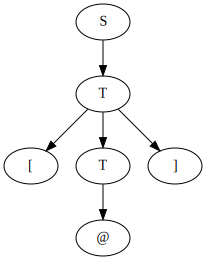

In [7]:
drawPT(parseS("['']", L, P))

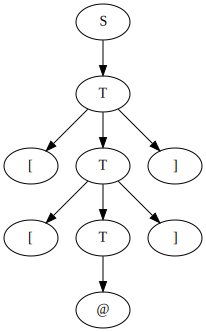

In [8]:
drawPT(parseS("[['']]", L, P))